In [5]:
import os

os.environ['KERAS_BACKEND'] = "tensorflow"

import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.layers import Input
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras import metrics

import numpy as np
import pickle


/home/michal/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Hyperparameters

In [6]:
INPUT_SHAPE = (224,224,3)
BATCH_SIZE = 32
EPOCHS = 5

# Code

In [7]:
input_tensor = Input(shape=INPUT_SHAPE, name = 'image_input')
# Also weights = 'imagenet' really important it takes weights from imagenet
model_vgg16_conv = VGG16(weights = 'imagenet', include_top=False, input_tensor=input_tensor)

In [8]:
import pandas as pd
df_train = pd.read_csv('./labels.csv')

In [16]:
#from tqdm import tqdm
import cv2
x_train = []
y_train = []

In [42]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)
# print(targets_series)

# create folders
import os, errno

dirs = ['test', 'train']
for dir in dirs:
    for breed in targets_series:
        try:
            os.makedirs('./'+dir+'/'+breed)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [45]:
# Creating ictionary with images id divided to breeds
# { buldog: [12rr,12r234,324234...]...}
dogs_dict = dict()
for breed in targets_series:
    dogs_dict.setdefault(breed, [])

In [ ]:
for index, row in df_train.iterrows():
    

In [41]:

# copy photos to specific folders
import pandas as pd
!pip install shutil
from shutil import copyfile

# copyfile(src, dst)
df_train = pd.read_csv('./labels.csv')
# print(df_train)

for index, row in df_train.iterrows():
    copyfile(src, dst)
    print(row['id'],row['breed'])

In [7]:
i = 0 
#for f, breed in tqdm(df_train.values):
for f, breed in df_train.values:
    img = cv2.imread('../train/{}.jpg'.format(f), 1)
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (INPUT_SHAPE[0], INPUT_SHAPE[1])))
    y_train.append(label)
    i += 1

In [8]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.

In [2]:
#import sklearn
from sklearn.model_selection import train_test_split
# dzieli po rowno stratify
# porownanie 2ch sieci 
# xception, CGG16< -----
# resnet i inception
# Przerzuc na foldery
# Teoria
# 1. Machine learning computer vision
# 2. Transfer Learning
# 3. OPis 2ch modeli
# 4. Wyniki 
# 5. Podsumowanie
# Do konca lutegeo SPIS TRESCI
# Do konca marcca 1 rozdzial
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.2, stratify=y_train)

ImportError: No module named 'sklearn.model_selection'

In [10]:
print ("Train: ", X_train.shape, Y_train.shape)
print ("Valid: ", X_valid.shape, Y_valid.shape)

Train:  (8177, 224, 224, 3) (8177, 120)
Valid:  (2045, 224, 224, 3) (2045, 120)


### Data generator

In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train_raw)

### Plot history

In [12]:
acc = []
val_acc = []
loss = []
val_loss = []

def unpack_history(history):
    global acc
    global val_acc
    global loss
    global val_loss
    acc += history.history['acc']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    val_loss += history.history['val_loss']
    
def plot_history():
    epochs = np.arange(len(acc)) + 1
    
    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(121)    
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)
    
    ax2 = fig.add_subplot(122)    
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title('Accuracy')
    #ax2.legend(loc='upper left');
    ax2.grid(True)
        
    plt.show()    
    
    met_dic = {}
    met_dic['loss'] = loss
    met_dic['val_loss'] = val_loss
    met_dic['acc'] = acc
    met_dic['val_acc'] = val_acc
    
    pickle.dump(met_dic, open( "metrics.p", "wb" ))
    

### Model

In [13]:
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten, Dense, Input, MaxPooling2D, Conv2D, Activation, BatchNormalization
from keras.callbacks import EarlyStopping

total_of_dog_breeds = 120
# Add a new top layer
# Get rid of 1st layer
output_vgg16_conv = model_vgg16_conv.output_shape[1:]

top_model = Sequential()
top_model.add(Flatten(input_shape=output_vgg16_conv))
top_model.add(Dense(total_of_dog_breeds, activation='softmax', name='predictions'))

# Witohut it it will retrain entire network !!!!
for layer in model_vgg16_conv.layers:
    layer.trainable = False

# Combine base and top
dog_model = Model([model_vgg16_conv.input],
              [top_model(model_vgg16_conv.output)])

dog_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', metrics.top_k_categorical_accuracy])

# https://stackoverflow.com/questions/43906048/keras-early-stopping
callbacks_list = [EarlyStopping(monitor='val_acc', patience=5, verbose=0)]
dog_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Transfer learning

Epoch 1/30
256/255 [==============================] - 99s 386ms/step - loss: 6.4488 - acc: 0.0727 - top_k_categorical_accuracy: 0.2047 - val_loss: 5.7218 - val_acc: 0.1501 - val_top_k_categorical_accuracy: 0.3487
Epoch 2/30
256/255 [==============================] - 79s 308ms/step - loss: 5.2348 - acc: 0.1981 - top_k_categorical_accuracy: 0.4095 - val_loss: 5.3415 - val_acc: 0.2112 - val_top_k_categorical_accuracy: 0.4323
Epoch 3/30
256/255 [==============================] - 79s 308ms/step - loss: 4.7327 - acc: 0.2509 - top_k_categorical_accuracy: 0.4902 - val_loss: 5.5644 - val_acc: 0.2044 - val_top_k_categorical_accuracy: 0.4313
Epoch 4/30
256/255 [==============================] - 79s 308ms/step - loss: 4.6086 - acc: 0.2849 - top_k_categorical_accuracy: 0.5329 - val_loss: 5.4018 - val_acc: 0.2279 - val_top_k_categorical_accuracy: 0.4875
Epoch 5/30
256/255 [==============================] - 83s 324ms/step - loss: 4.4004 - acc: 0.3373 - top_k_categorical_accuracy: 0.5722 - val_loss: 5

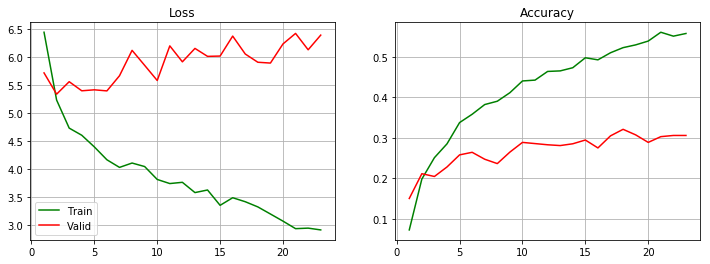

In [15]:
EPOCHS = 30
history = dog_model.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    validation_data=(X_valid, Y_valid),
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) / BATCH_SIZE, 
    callbacks=callbacks_list
                    )

unpack_history(history)
plot_history()

dog_model.save_weights('dog_model_weights_transfer_learning_0.h5')

In [43]:
def evaluate_dog_model():
    evaluate = dog_model.evaluate(X_valid, Y_valid)
    print ('Valid LOSS: {:.4f}, ACC: {:.2f}%, ACC5: {:.2f}%'.format(evaluate[0], 100*evaluate[1], 100*evaluate[2]))
evaluate_dog_model()

2045/2045 [==============================] - 12s 6ms/step
Valid LOSS: 6.3978, ACC: 30.56%, ACC5: 57.26%


### Fine tuning

W zasadzie to Fine Tuning to jest taka trochę sztuka dla sztuki. Mamy 10 tys obrazków i ponad 3 mln parametrów, nie widzę sensu w zwiększaniu liczby parametrów. Mimo to można spróbować :)

In [71]:
dog_model.load_weights("./dog_model_weights_transfer_learning_0.h5")

In [72]:
FINETUNE_LAYER = 17
print (dog_model.layers[FINETUNE_LAYER].name)

block5_conv3


In [73]:
from keras.optimizers import SGD

for layer in dog_model.layers[:FINETUNE_LAYER]:
    layer.trainable = False
    
for layer in dog_model.layers[FINETUNE_LAYER:]:
    layer.trainable = True

dog_model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy', metrics.top_k_categorical_accuracy])


In [74]:
callbacks_list = [EarlyStopping(monitor='val_acc', patience=2, verbose=0)]

Epoch 1/5
256/255 [==============================] - 82s 320ms/step - loss: 1.8321 - acc: 0.6848 - top_k_categorical_accuracy: 0.8748 - val_loss: 4.5743 - val_acc: 0.3550 - val_top_k_categorical_accuracy: 0.6425
Epoch 2/5
256/255 [==============================] - 80s 312ms/step - loss: 1.4992 - acc: 0.7295 - top_k_categorical_accuracy: 0.8949 - val_loss: 4.1031 - val_acc: 0.3711 - val_top_k_categorical_accuracy: 0.6489
Epoch 3/5
256/255 [==============================] - 80s 311ms/step - loss: 1.2600 - acc: 0.7339 - top_k_categorical_accuracy: 0.9094 - val_loss: 3.8770 - val_acc: 0.3716 - val_top_k_categorical_accuracy: 0.6479
Epoch 4/5
256/255 [==============================] - 87s 338ms/step - loss: 1.1100 - acc: 0.7519 - top_k_categorical_accuracy: 0.9152 - val_loss: 3.7588 - val_acc: 0.3687 - val_top_k_categorical_accuracy: 0.6562
Epoch 5/5
256/255 [==============================] - 80s 314ms/step - loss: 1.0390 - acc: 0.7584 - top_k_categorical_accuracy: 0.9160 - val_loss: 3.6914

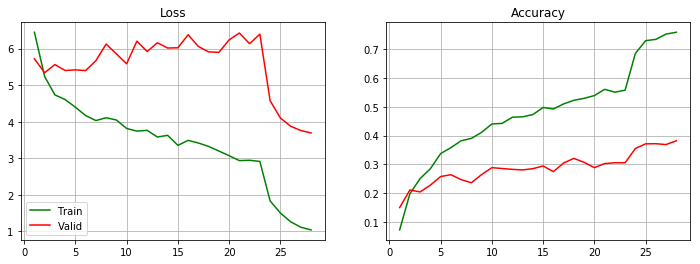

In [75]:
EPOCHS = 5
history = dog_model.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    validation_data=(X_valid, Y_valid),
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) / BATCH_SIZE, 
    callbacks=callbacks_list
                    )

unpack_history(history)
plot_history()

dog_model.save_weights('dog_model_weights_fine_tuning_0.h5')


In [78]:
evaluate_dog_model()

2045/2045 [==============================] - 12s 6ms/step
Valid LOSS: 3.6914, ACC: 38.19%, ACC5: 66.31%
